<a href="https://colab.research.google.com/github/mathluva/Bert-Toxic-Comments/blob/main/Toxic_Comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!nvidia-smi

Thu Feb 18 21:49:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import tensorflow as tf

In [5]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 507), reused 1383 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.01 MiB | 27.40 MiB/s, done.
Resolving deltas: 100% (507/507), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [6]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

     |████████████████████████████████| 71kB 5.8MB/s 
     |████████████████████████████████| 215kB 10.7MB/s 
     |████████████████████████████████| 296kB 13.2MB/s 
     |████████████████████████████████| 102kB 10.1MB/s 
     |████████████████████████████████| 25.9MB 125kB/s 
     |████████████████████████████████| 174kB 56.9MB/s 
     |████████████████████████████████| 3.7MB 55.8MB/s 
     |████████████████████████████████| 706kB 59.1MB/s 
     |████████████████████████████████| 358kB 59.1MB/s 
     |████████████████████████████████| 1.2MB 57.8MB/s 
     |████████████████████████████████| 11.5MB 203kB/s 
     |████████████████████████████████| 37.6MB 86kB/s 
     |████████████████████████████████| 645kB 57.8MB/s 
     |████████████████████████████████| 2.2MB 58.5MB/s 
     |████████████████████████████████| 102kB 15.2MB/s 
     |████████████████████████████████| 81kB 13.8MB/s 
     |████████████████████████████████| 51kB 9.6MB/s 
ERROR: pandas-gbq 0.13.3 has requirement google-cloud-

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import files
uploaded = files.upload()

Saving train_preprocessed.csv to train_preprocessed.csv


In [4]:
import io
df = pd.read_csv(io.BytesIO(uploaded['train_preprocessed.csv']))

In [5]:
df.shape

(159571, 10)

In [9]:
df = df[['comment_text', 'toxicity']]
df

,comment_text,toxicity
0,explanation why the edits made under my userna...,0.0
1,d aww he matches this background colour i m s...,0.0
2,hey man i m really not trying to edit war it...,0.0
3,more i can t make any real suggestions on im...,0.0
4,you sir are my hero any chance you remember...,0.0
...,...,...
159566,and for the second time of asking when your ...,0.0
159567,you should be ashamed of yourself that is a ho...,0.0
159568,spitzer umm theres no actual article for pros...,0.0
159569,and it looks like it was actually you who put ...,0.0


In [10]:
df.head()

,comment_text,toxicity
0,explanation why the edits made under my userna...,0.0
1,d aww he matches this background colour i m s...,0.0
2,hey man i m really not trying to edit war it...,0.0
3,more i can t make any real suggestions on im...,0.0
4,you sir are my hero any chance you remember...,0.0


<AxesSubplot:title={'center':'Toxicity'}, ylabel='Frequency'>

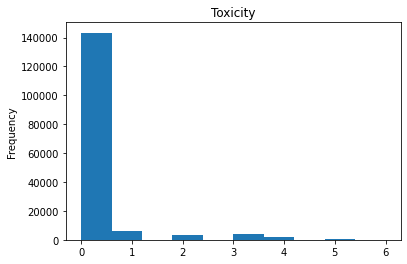

In [11]:
df['toxicity'].plot(kind = 'hist', title = 'Toxicity')

In [12]:
train_df, remaining = train_test_split(df, random_state = 42, train_size = .8, stratify = df['toxicity'].values)
valid_df, _ = train_test_split(remaining, random_state = 42, train_size = .2, stratify = remaining['toxicity'].values)

In [13]:
print(f'remaining shape: {remaining.shape}')
print(f'training shape: {train_df.shape}')
print(f'validation shape: {valid_df.shape}')

remaining shape: (31915, 2)
training shape: (127656, 2)
validation shape: (6383, 2)


In [ ]:
x_train.shape, y_train.shape,x_valid.shape, y_valid.shape

((127656,), (127656, 6), (6383,), (6383, 6))

In [15]:
df['toxicity'].unique()

array([0., 4., 1., 3., 2., 5., 6.])

In [14]:
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices((train_df['comment_text'].values, train_df['toxicity'].values))
    valid_data= tf.data.Dataset.from_tensor_slices((valid_df['comment_text'].values, valid_df['toxicity'].values))

#print one pair in tensorflow dataset to "take" a look at 
for text, label in train_data.take(1):
  print(text)
  print(label)

tf.Tensor(b'comment signed by jackthomas', shape=(), dtype=string)
tf.Tensor(0.0, shape=(), dtype=float64)


In [16]:
label_list =[0,1,2,3,4, 5,6]
max_seq_length = 128 #BERT has max length of 512/maximum length of (token) input sequences


# Get BERT layer and tokenizer:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)

vocab_file = vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

#use uncase version of BERT
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

#FullTokenizer from BERT handles all the preprocessing of incoming raw text data
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)



In [20]:
tokenizer.wordpiece_tokenizer.tokenize("hello, how are you?")

['hello', '##,', 'how', 'are', 'you', '##?']

In [21]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize("hello, how are you?"))

[7592, 29623, 2129, 2024, 2017, 29632]

In [23]:
# This provides a function to convert row to input features and label
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  
  #input example used by BERT
  example = classifier_data_lib.InputExample(guid = None, text_a = text.numpy(),
                                             text_b = None, 
                                             label = label.numpy())
   # 0 for first index
  feature = classifier_data_lib.convert_single_example(0,example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)
  #can't directly use this function to create input data structure
  #wrap it in tensorflow python class

In [24]:
 def to_feature_map(text, label):
  #wrapping to_feature function, input is text, label, tensor output is int32 -create one for each
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp = [text, label], Tout = [tf.int32,tf.int32, tf.int32, tf.int32])

  #create padding for constant sequence length
  input_ids.set_shape(max_seq_length)
  input_mask.set_shape(max_seq_length)
  segment_ids.set_shape(max_seq_length)
  label_id.set_shape([]) #can leave blank

  #bundle features into dictionary
  x = { 'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids
       }
  
  return (x, label_id)


In [25]:
with tf.device('/cpu:0'):
  # train, transforming original train_data using the function and  wrapper created by mapping 
  #map applies user defined function to each element of the input data set, because they are independent they can be done parallel
  #AUTOTUNE allows tf to determing the optimal size for // calls
  #prefetch data ahead of time without waiting for current
 
  train_data = (train_data.map(to_feature_map, num_parallel_calls = tf.data.experimental.AUTOTUNE).shuffle(1000)
  .batch(32, drop_remainder = True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid, do everything except shuffling
  valid_data = (valid_data.map(to_feature_map, num_parallel_calls = tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder = True)
  .prefetch( tf.data.experimental.AUTOTUNE))
  
  

In [26]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [27]:
#define classification model
#input token ids, input mask, input type ids ---> pass these features to BERT LAYER, it gives pooled_output and sequence_output
#look at documentation for pooled_output (use for classification), sequence_output
#add CLS token 

#copy from documentation
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  #segment_id from doc
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output) #hyperparameter, add dropout regularization
  output = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'output')(drop) # sigmoid for probability
  model = tf.keras.Model(
     inputs ={
         'input_word_ids': input_word_ids,
       'input_mask': input_mask,
       'input_type_ids': input_type_ids
       },
       outputs = output)
  return model

In [28]:
model = create_model()
#very small learning rate for this activity
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics =[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

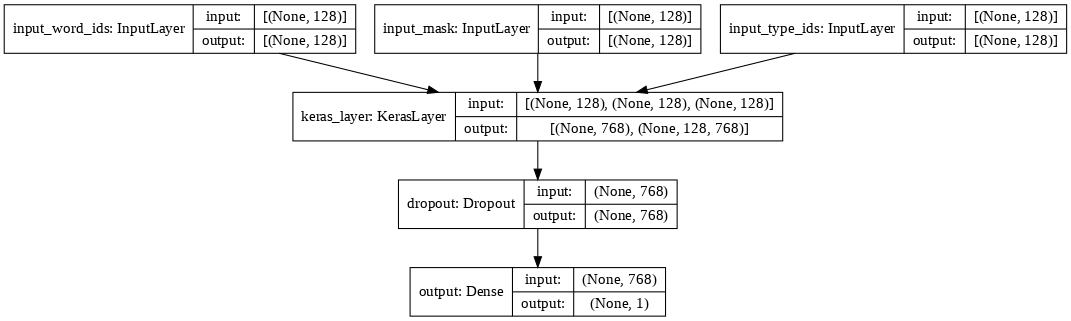

In [29]:
tf.keras.utils.plot_model(model = model, show_shapes=True, dpi = 76)

In [31]:
# Train model
#fit data to model
#takes about 10 min to train
epochs = 1 
history = model.fit(train_data, validation_data= valid_data, epochs = epochs, verbose =1)



3989/3989 [==============================] - 3372s 845ms/step - loss: -6.9582 - binary_accuracy: 0.8939 - val_loss: -9.0564 - val_binary_accuracy: 0.8987


In [44]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()


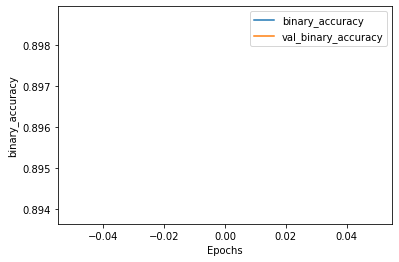

In [46]:
plot_graphs(history, 'binary_accuracy')

In [53]:
#practice examples
sample_example = ["you are ignorant", " I am not ignorant", " I fucking love this song"]
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0] *len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold = .4 #between 0 and 1
['Nasty' if pred >=threshold else 'Good' for pred in preds]

['Nasty', 'Good', 'Nasty']